### Libraries, functions etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.special import expit

import sys
sys.path.insert(1, '../')

import measures
from model import LogReg
from preprocessing import Preprocessor
import experiments

### Loading data

In [3]:
bank_df = pd.read_csv('../data/bank-additional-full.csv', sep=';')

X_bank=bank_df.drop(columns='y')
y_bank=(bank_df['y'] == 'yes').astype(int)

prep_bank = Preprocessor()

In [64]:
X_bank_train, X_bank_test, y_bank_train, y_bank_test = prep_bank.train_test_split(X_bank, y_bank)

Basic data info:

In [77]:
bank_df.shape

(41188, 21)

In [78]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

No missing values in data, 10 categorical features.

In [79]:
y_bank.mean()

0.11265417111780131

Many observations but target is very imbalanced.

In [65]:
X_train=X_bank_train.copy()
X_test=X_bank_test.copy()
y_train=y_bank_train.copy()
y_test=y_bank_test.copy()

#One Hot Encoding
X_train = prep_bank.one_hot_encoding_fit_transform(X_train)
X_test = prep_bank.one_hot_encoding_transform(X_test)

#Collinearities removal
X_train = prep_bank.remove_multicollinearity_fit_transform(X_train)
X_test = prep_bank.remove_multicollinearity_transform(X_test)

#X_train=X_train.to_numpy()
y_train=y_train.to_numpy()
#X_test=X_test.to_numpy()
y_test=y_test.to_numpy()

/home/pawel/.local/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


42 numerical features left in dataset  0  categorical


#### 1. Convergence analysis: check how the value of log-likelihood function depends on the number of iterations for 4 above algorithms.

In [66]:
lr=0.01
n_epochs=1000

lr_models = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=32),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=lr, beta_1=0.9,
                    beta_2=0.99, epsilon=1e-8)
 }

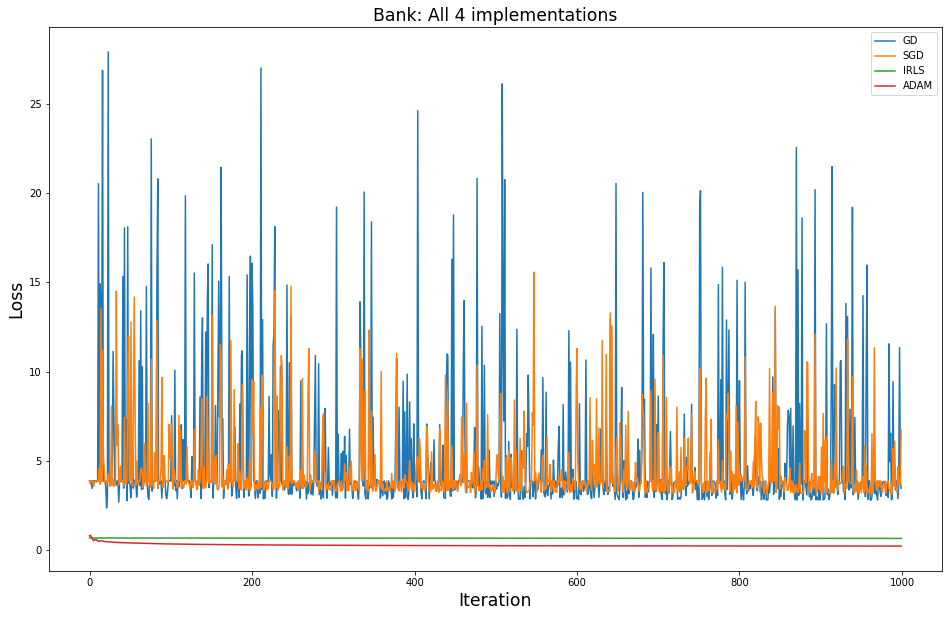

In [67]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models.items():
    model.train(X_train.to_numpy(), y_train)
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('Bank: All 4 implementations',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.savefig('Bank_conv_01.svg')
plt.show()

#### 1(b)

In [68]:
y_train_2=y_bank_train.copy()
y_test_2=y_bank_test.copy()

# Rebalancing the training dataset
X_train_2, y_train_2 = prep_bank.class_balancing(X_train, y_train_2)

#Scaling the dataset
s = StandardScaler()
X_train_3 = s.fit_transform(X_train_2)
X_test_3 = s.transform(X_test)
y_train_2 = y_train_2.to_numpy()
y_train_3 = y_train_2.copy()
y_test_3 = y_test.copy()

Training dataset has now  54822 obervations. 50.0  percent is in positive group.


Only target balancing:

In [69]:
lr_models_2 = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=32),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=lr, beta_1=0.9,
                    beta_2=0.99, epsilon=1e-8)
 }

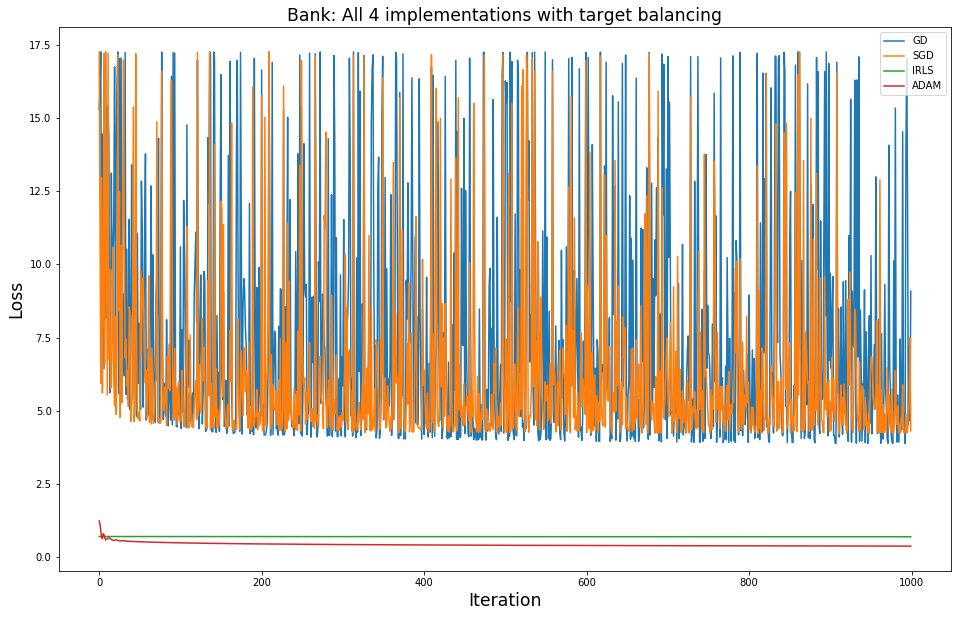

In [71]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models_2.items():
    model.train(X_train_2.to_numpy(), y_train_2)
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('Bank: All 4 implementations with target balancing',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.savefig('Bank_conv_02.svg')
plt.show()

Target balancing and data scaling

In [72]:
lr_models_3 = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=32),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=lr, beta_1=0.9,
                    beta_2=0.99, epsilon=1e-8)
 }

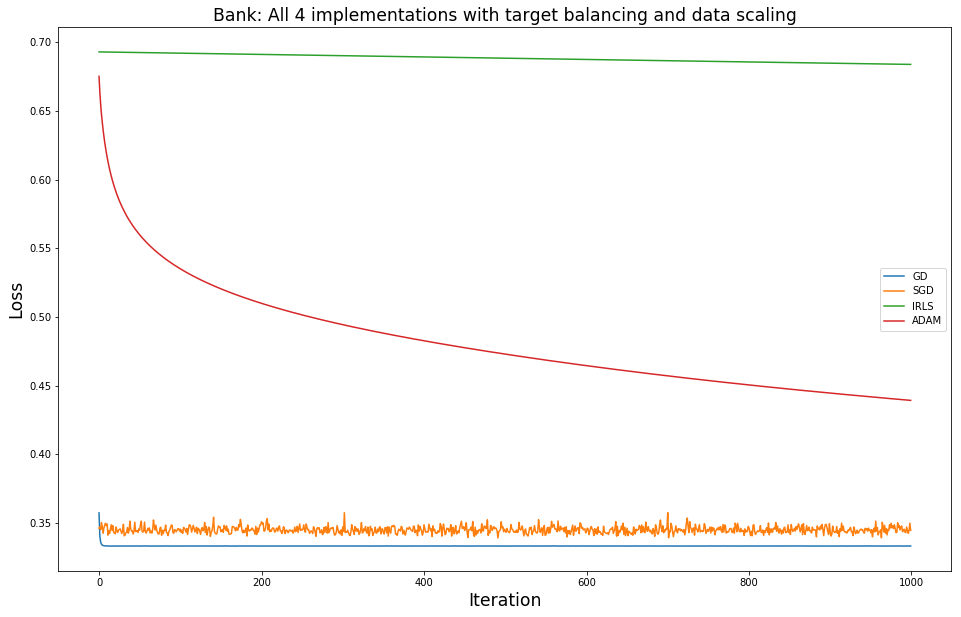

In [73]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models_3.items():
    model.train(X_train_3, y_train_3)
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('Bank: All 4 implementations with target balancing and data scaling',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.savefig('Bank_conv_03.svg')
plt.show()

In [74]:
comp_df = pd.DataFrame(columns=['algorithm', 'transform', 'f_score'])
for model_name in lr_models:
    f_no_scal = measures.f_measure(lr_models[model_name].predict(X_test), y_test)
    f_balanced = measures.f_measure(lr_models_2[model_name].predict(X_test), y_test)
    f_scaled = measures.f_measure(lr_models_3[model_name].predict(X_test_3), y_test_3)
    comp_df = pd.concat((comp_df, pd.DataFrame({'algorithm': [model_name]*3,
                                                'transform': ['None', 'Balancing', 'Balancing & scaling'],
                                                'f_score': [f_no_scal, f_balanced, f_scaled]})),
                        ignore_index=True)

In [75]:
comp_df

,algorithm,transform,f_score
0,GD,None,0.445841
1,GD,Balancing,0.570483
2,GD,Balancing & scaling,0.581934
3,SGD,None,0.557111
4,SGD,Balancing,0.566938
5,SGD,Balancing & scaling,0.581606
6,IRLS,None,0.438566
7,IRLS,Balancing,0.576485
8,IRLS,Balancing & scaling,0.576485
9,ADAM,None,0.402575


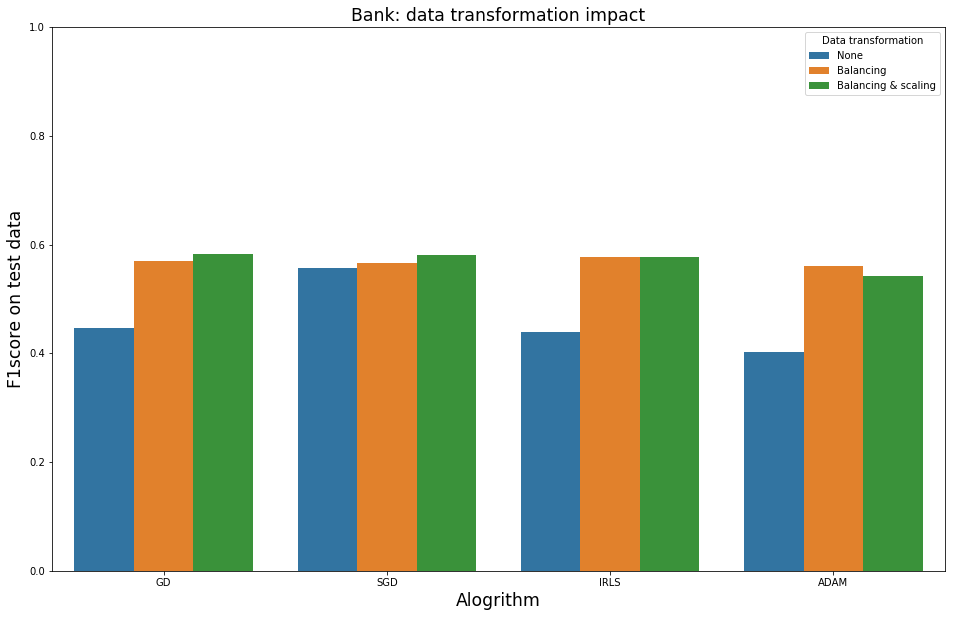

In [76]:
plt.figure(figsize=(16, 10))
sns.barplot(x='algorithm', y='f_score', data=comp_df, hue='transform')
plt.legend(loc=1, title='Data transformation')
plt.ylim(0, 1)
plt.title('Bank: data transformation impact', fontsize='xx-large')
plt.xlabel('Alogrithm', fontsize='xx-large')
plt.ylabel('F1score on test data', fontsize='xx-large')
plt.savefig('Bank_transformation_impact.svg')
plt.show()

No doubt on the best data transformation combination

#### 2. Check how the value of learning rate and other parameters affect the results.

In [49]:
tested_l_rates=np.linspace(start=0.2,stop=1e-5,num=6)
tested_algorithms={'GD': 'Gradient Descent','SGD':'Stochastic Gradient Descent','ADAM':'Adaptive Moment Estimation'}

res_test_learning_rates=experiments.test_learning_rates(X_train=X_train_3,
                                                        y_train=y_train_3,
                                                        X_test=X_test_3,
                                                        y_test=y_test_3,
                                                        l_rates=tested_l_rates,
                                                        algorithms=tested_algorithms,
                                                        n_epochs=50
                                                       )

res_test_learning_rates

,learning_rate,method,accuracy,recall,precision,F_measure
0,0.200000,GD,0.860,0.861,0.438,0.581
1,0.200000,SGD,0.827,0.870,0.382,0.531
2,0.200000,ADAM,0.860,0.865,0.439,0.582
3,0.160002,GD,0.859,0.865,0.436,0.580
4,0.160002,SGD,0.829,0.868,0.385,0.533
5,0.160002,ADAM,0.860,0.854,0.439,0.580
6,0.120004,GD,0.858,0.866,0.434,0.579
7,0.120004,SGD,0.832,0.872,0.390,0.539
8,0.120004,ADAM,0.860,0.840,0.437,0.575
9,0.080006,GD,0.859,0.868,0.436,0.580


In [50]:
res_test_learning_rates.sort_values(['method', 'accuracy', 'F_measure'], ascending=[True, False, False])\
                       .groupby('method').head(2)

,learning_rate,method,accuracy,recall,precision,F_measure
2,0.200000,ADAM,0.860,0.865,0.439,0.582
5,0.160002,ADAM,0.860,0.854,0.439,0.580
0,0.200000,GD,0.860,0.861,0.438,0.581
3,0.160002,GD,0.859,0.865,0.436,0.580
16,0.000010,SGD,0.862,0.860,0.443,0.585
13,0.040008,SGD,0.841,0.883,0.406,0.556


Very small value of optimal learning rate of SGD draws attention.

In [51]:
tested_betas_1=np.linspace(start=0.75,stop=.97,num=12)
tested_betas_2=np.linspace(start=0.90,stop=0.99,num=10)
tested_lr = [0.2, 0.1, 0.02]

res_test_betas=experiments.test_betas(X_train=X_train_3, 
                                      y_train=y_train_3,
                                      X_test=X_test_3,
                                      y_test=y_test_3,
                                      tested_betas1=tested_betas_1,
                                      tested_betas2=tested_betas_2,
                                      learning_rates=tested_lr)

res_test_betas.sort_values(by=['accuracy','F_measure','recall','precision'],ascending=False).head(10)

,beta1,beta2,accuracy,recall,precision,F_measure,lr
139,0.77,0.99,0.860348,0.863793,0.439089,0.582220,0.1
129,0.75,0.99,0.860348,0.862931,0.439035,0.581977,0.1
149,0.79,0.99,0.860251,0.863793,0.438896,0.582051,0.1
159,0.81,0.99,0.860251,0.863793,0.438896,0.582051,0.1
169,0.83,0.99,0.860153,0.863793,0.438704,0.581882,0.1
179,0.85,0.99,0.860153,0.863793,0.438704,0.581882,0.1
199,0.89,0.99,0.860153,0.862931,0.438650,0.581639,0.1
177,0.85,0.97,0.860056,0.868103,0.438780,0.582923,0.1
178,0.85,0.98,0.860056,0.866379,0.438673,0.582440,0.1
189,0.87,0.99,0.860056,0.863793,0.438512,0.581713,0.1


This time, relatively small value of beta1 and very high of beta2 (responsible for low input of derivative of each current epoch in tha variance) appeared to be the best parameters.

#### 4. Compare the classification performance of logistic regression (try all 4 methods: IWLS, GD, SGD and ADAM) and 3 popular classification methods: LDA, QDA and KNN. Use the performance measures implemented in Part 2 and datasets prepared in Part 1. The performance measures should be calculated on test set. If the given algorithm does not converge, within 1000 iterations, stop the algorithm and use the solutions from the last iteration.

In [52]:
n_epochs=1000

batch_size_gd=0.1 # 10% of training subset
lr_gd=0.2

lr_sgd=0.00001

lr_adam=0.1
beta1_adam=0.77
beta2_adam=0.99

models = {
    'GD': LogReg(optimization='Gradient Descent',
                 learning_rate=lr_gd,
                 epochs=n_epochs,
                 batch_size=batch_size_gd),
    'SGD': LogReg(optimization='Stochastic Gradient Descent',
                  learning_rate=lr_sgd,
                  epochs=n_epochs),
    'IRLS': LogReg(optimization='Iterative Reweighted Least Squares',
                   epochs=n_epochs),
    'ADAM': LogReg(optimization='Adaptive Moment Estimation',
                   epochs=n_epochs,
                   learning_rate=lr_adam,
                   beta_1=beta1_adam,
                   beta_2=beta2_adam,
                   epsilon=1e-8),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'LR': LogisticRegression(max_iter=n_epochs),
    'kNN': KNeighborsClassifier()
}


In [53]:
res_final=experiments.final_comparisson(X_train=X_train_3,
                                        y_train=y_train_3,
                                        X_test=X_test_3,
                                        y_test=y_test_3,
                                        models=models)

res_final.sort_values(by=['accuracy','f_measure','recall','precision'],ascending=False)

/home/pawel/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,model,accuracy,recall,precision,f_measure
2,IRLS,0.862096,0.831897,0.440639,0.576119
4,LDA,0.862096,0.831897,0.440639,0.576119
0,GD,0.858697,0.868966,0.436175,0.580812
1,SGD,0.858114,0.868103,0.434989,0.579568
3,ADAM,0.858114,0.868103,0.434989,0.579568
6,LR,0.858114,0.868103,0.434989,0.579568
7,kNN,0.832864,0.593966,0.355338,0.444660
5,QDA,0.122074,0.999138,0.113650,0.204085


#### 5. Comparing convergence analysis for the "best" parameters.

In [63]:
measures.get_measures(models['IRLS'].predict(X_test_3), y_test_3)

(0.8620957560454501,
 0.8318965517241379,
 0.4406392694063927,
 0.5761194029850746)

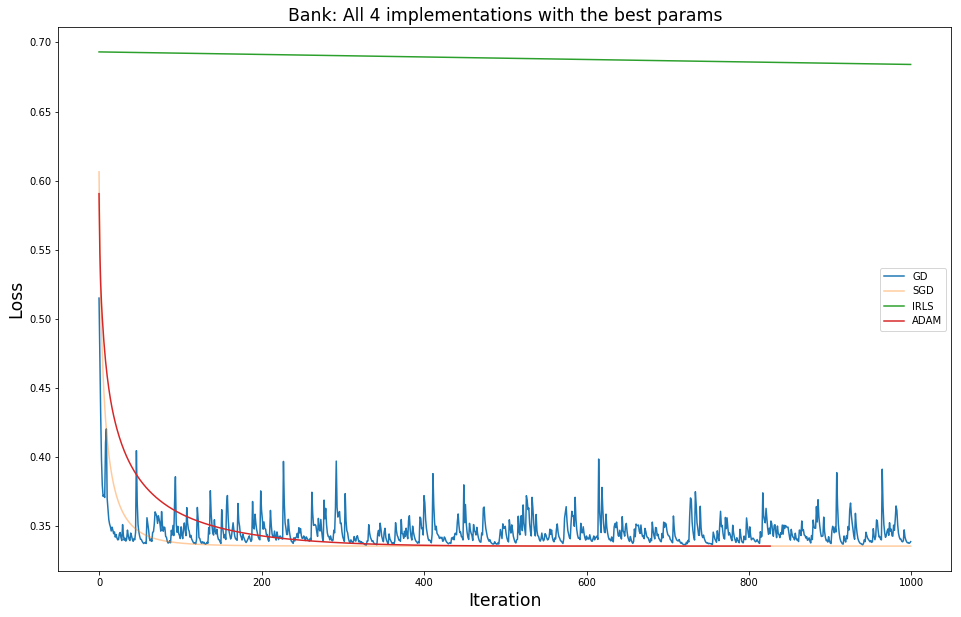

In [57]:
plt.figure(figsize=(16, 10))
for model_name, model in models.items():
    if model_name in ['GD', 'SGD', 'IRLS', 'ADAM']:
        losses[model_name]=model.get_optimizer_training_losses()
        a = 0.4 if 'SGD' == model_name else 1
        plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name, alpha = a)
plt.title('Bank: All 4 implementations with the best params',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.savefig('bank_conv_04.svg')
plt.show()

#### 6. Comparison of coefficients in different logistic regression algorithms:

In [54]:
lr_coefs = {alg: models[alg].get_optimizer_training_w().flatten() for alg in ['GD', 'SGD', 'IRLS', 'ADAM']}
lr_coefs['LR'] = np.concatenate((models['LR'].intercept_, models['LR'].coef_.flatten()))

In [55]:
pd.DataFrame(lr_coefs)

,GD,SGD,IRLS,ADAM,LR
0,0.186511,0.172440,7.988656e-07,0.171117,0.172170
1,2.642614,2.507830,1.836908e-02,2.507803,2.506038
2,-0.095169,-0.111447,-7.847562e-04,-0.111443,-0.111409
3,0.021742,0.004862,3.442769e-04,0.004810,0.004977
4,-1.413523,-1.350491,-1.391804e-02,-1.350728,-1.349617
5,0.091020,0.078009,8.440366e-04,0.077990,0.077989
6,-0.083457,-0.124595,-1.177705e-03,-0.124474,-0.124470
7,0.014777,-0.002142,4.317917e-05,-0.002111,-0.002170
8,-0.045697,-0.051064,-3.291038e-04,-0.051019,-0.050996
9,-0.042504,-0.045451,-3.814197e-04,-0.045457,-0.045456


## Conclusions

- As usually, convergence on basic version of data is unstable. Data scaling reduces the oscillations
- IRLS loss values converged very slowly but the metrics on test data were not significantly worse than in Gradient Descent methods. Maybe GD algorithms tend to overfit.
- In the final experiments, GD reached the highest value of F1-score. IRLS and LDA had the highest accuracy but it is not that important on imbalanced data.

- Probably for the first time sklearn LR and ADAM coefficients were almost equal